In [6]:
import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage

OUT_DIR = "/content/clustering_results"
os.makedirs(OUT_DIR, exist_ok=True)
print("Saída em:", OUT_DIR)

# 1 - Escolha: usar CSV real ou dados sintéticos
csv_path = "/content/sensores_maquina_2000.csv"
df = pd.read_csv(csv_path)
display(df.head())
print("Shape:", df.shape)
print("Colunas:", df.columns.tolist())
display(df.head())
df.to_csv(os.path.join(OUT_DIR,"input_used.csv"), index=False)





Saída em: /content/clustering_results


,temperatura,vibracao,corrente,pressao
0,69.462765,2.596625,11.945222,3.386926
1,69.360246,2.496373,11.253077,4.341761
2,75.962905,3.073426,12.453586,3.607070
3,70.185746,1.967126,11.871341,3.319334
4,61.388438,3.048886,11.286415,3.976820


Shape: (2000, 4)
Colunas: ['temperatura', 'vibracao', 'corrente', 'pressao']


,temperatura,vibracao,corrente,pressao
0,69.462765,2.596625,11.945222,3.386926
1,69.360246,2.496373,11.253077,4.341761
2,75.962905,3.073426,12.453586,3.607070
3,70.185746,1.967126,11.871341,3.319334
4,61.388438,3.048886,11.286415,3.976820


Missing por coluna:
 temperatura    0
vibracao       0
corrente       0
pressao        0
dtype: int64
Explained variance ratio (2 PCs): [0.72932261 0.11520016]


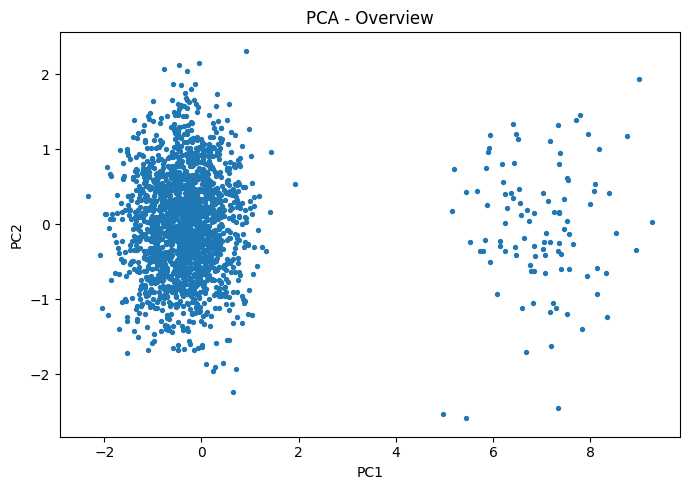

In [7]:
# 2 - Missing e normalização
print("Missing por coluna:\n", df.isna().sum())
# Se houver missing, trate aqui (ex.: df = df.dropna() ou df.fillna(df.mean()))
scaler = StandardScaler()
X = df.values
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print("Explained variance ratio (2 PCs):", pca.explained_variance_ratio_)
plt.figure(figsize=(7,5))
plt.scatter(X_pca[:,0], X_pca[:,1], s=8)
plt.title("PCA - Overview")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR,"pca_overview.png"))
plt.show()


K testados: [2, 3, 4, 5, 6]
Silhouette scores: [0.79, 0.22, 0.223, 0.198, 0.199]
Melhor k (por Silhouette): 2


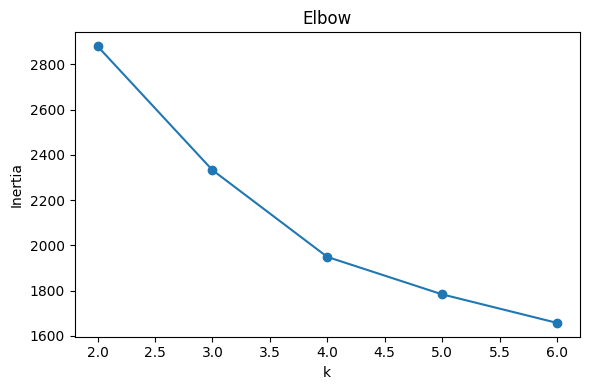

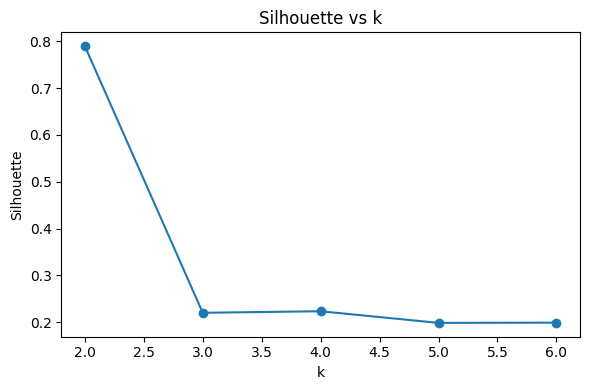

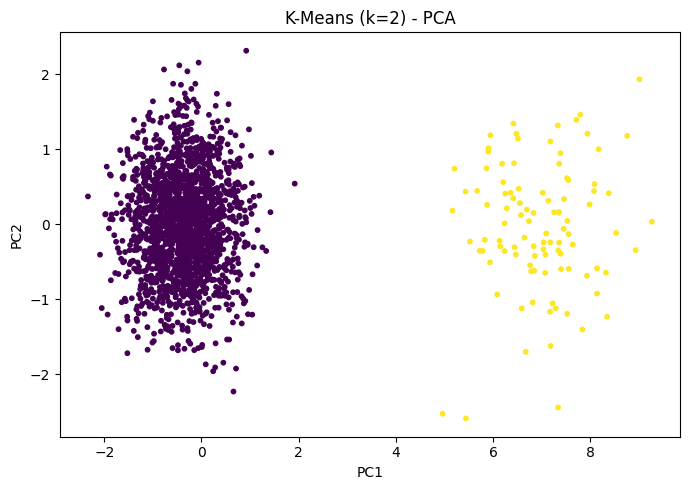

In [8]:
# 3 - K-Means
inertias = []
sil_scores = []
k_range = list(range(2,7))
labels_dict = {}
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labs = km.fit_predict(X_scaled)
    labels_dict[k] = labs
    inertias.append(float(km.inertia_))
    sil_scores.append(float(silhouette_score(X_scaled, labs)))

best_k = k_range[int(np.argmax(sil_scores))]
print("K testados:", k_range)
print("Silhouette scores:", [round(s,3) for s in sil_scores])
print("Melhor k (por Silhouette):", best_k)

plt.figure(figsize=(6,4))
plt.plot(k_range, inertias, marker='o')
plt.xlabel("k"); plt.ylabel("Inertia"); plt.title("Elbow")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR,"elbow_inertia.png"))
plt.show()

plt.figure(figsize=(6,4))
plt.plot(k_range, sil_scores, marker='o')
plt.xlabel("k"); plt.ylabel("Silhouette"); plt.title("Silhouette vs k")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR,"silhouette_scores.png"))
plt.show()

plt.figure(figsize=(7,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_dict[best_k], s=10)
plt.title(f"K-Means (k={best_k}) - PCA")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR,f"kmeans_k{best_k}_pca.png"))
plt.show()


,eps,min_samples,n_noise,n_clusters
0,0.3,3,71,5
1,0.3,5,96,4
2,0.3,8,123,3
3,0.5,3,12,8
4,0.5,5,37,5
5,0.5,8,50,3
6,0.8,3,0,8
7,0.8,5,0,8
8,0.8,8,11,7
9,1.0,3,0,7


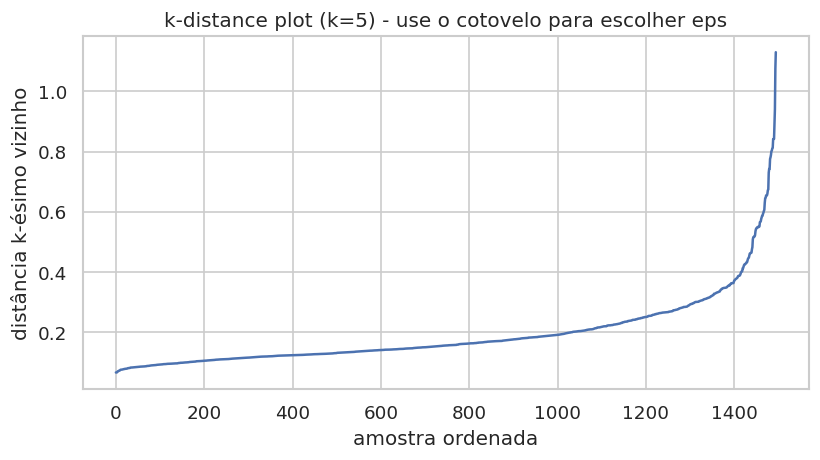

DBSCAN chosen eps=0.8, min_samples=5 -> n_noise=0, n_clusters=8


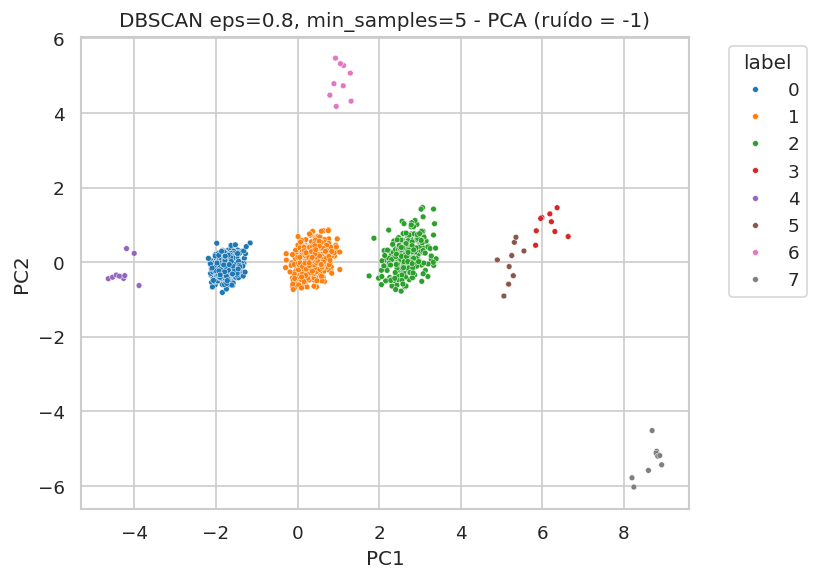

In [ ]:
# 4 - DBSCAN
eps_values = [0.2,0.3,0.5,0.8,1.0,1.2,1.5]
min_samples_values = [3,5,8]
db_grid = {}
for eps in eps_values:
    for ms in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=ms)
        labs = db.fit_predict(X_scaled)
        n_noise = int((labs == -1).sum())
        n_clusters = len(set(labs)) - (1 if -1 in labs else 0)
        db_grid[(eps,ms)] = {'n_noise': n_noise, 'n_clusters': n_clusters}

# Mostrar como tabela (parte)
rows = []
for (eps,ms),v in db_grid.items():
    rows.append({'eps':eps,'min_samples':ms,'n_noise':v['n_noise'],'n_clusters':v['n_clusters']})
display(pd.DataFrame(rows).sort_values(['eps','min_samples']).head(30))
pd.DataFrame(rows).to_csv(os.path.join(OUT_DIR,"dbscan_grid_summary.csv"), index=False)

# k-distance plot para k = 5 (ajuste se quiser outro)
from sklearn.neighbors import NearestNeighbors
k = 5
nbrs = NearestNeighbors(n_neighbors=k).fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)
kdist = np.sort(distances[:,k-1])
plt.figure(figsize=(7,4))
plt.plot(kdist)
plt.title(f"k-distance plot (k={k})")
plt.ylabel("distância k-ésimo vizinho")
plt.xlabel("amostras ordenadas")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR,"k_distance_plot.png"))
plt.show()

# Escolha parâmetros representativos (ajuste conforme tabela/k-distance)
chosen = (0.8,5)
db = DBSCAN(eps=chosen[0], min_samples=chosen[1])
db_labels = db.fit_predict(X_scaled)
n_noise = int((db_labels == -1).sum())
n_clusters = len(set(db_labels)) - (1 if -1 in db_labels else 0)
print("Chosen DBSCAN:", chosen, "n_noise:", n_noise, "n_clusters:", n_clusters)

plt.figure(figsize=(7,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=db_labels, s=10)
plt.title(f"DBSCAN eps={chosen[0]}, min_samples={chosen[1]} - PCA")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR,"dbscan_chosen_pca.png"))
plt.show()


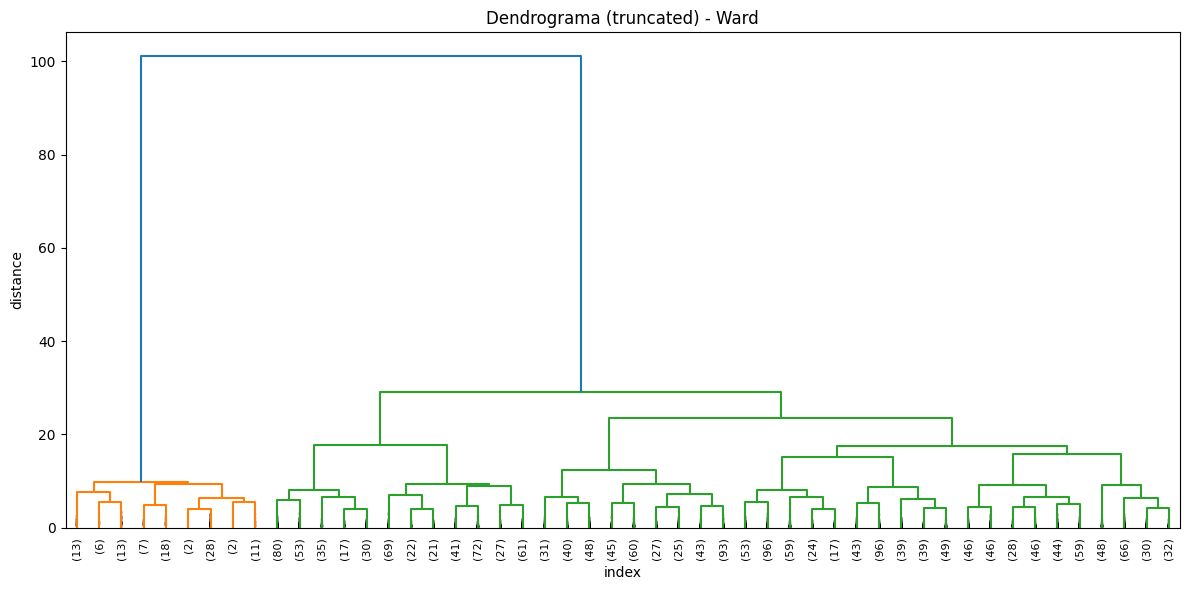

Melhor por linkage (n_clusters, silhouette): {'ward': {'n_clusters': 2, 'silhouette': 0.7898644627622996}, 'complete': {'n_clusters': 2, 'silhouette': 0.7898644627622996}, 'average': {'n_clusters': 2, 'silhouette': 0.7898644627622996}}


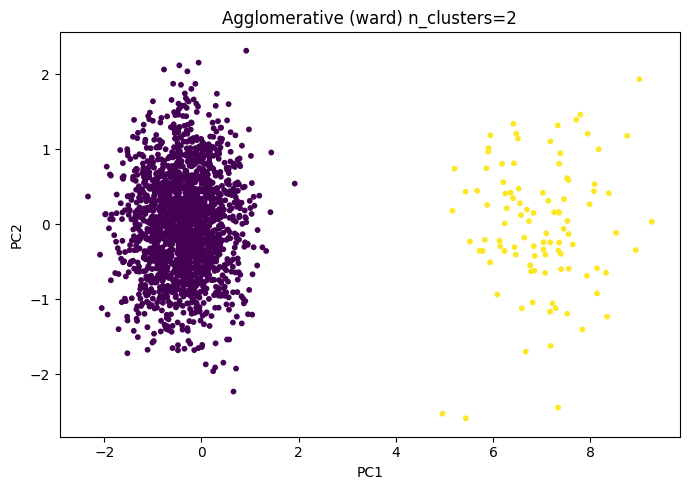

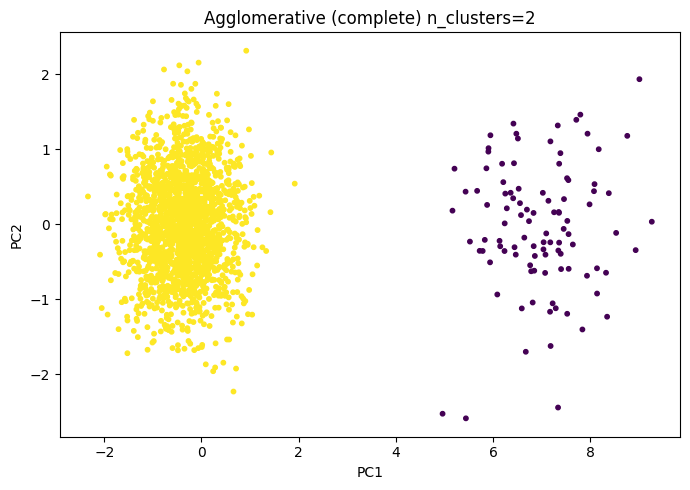

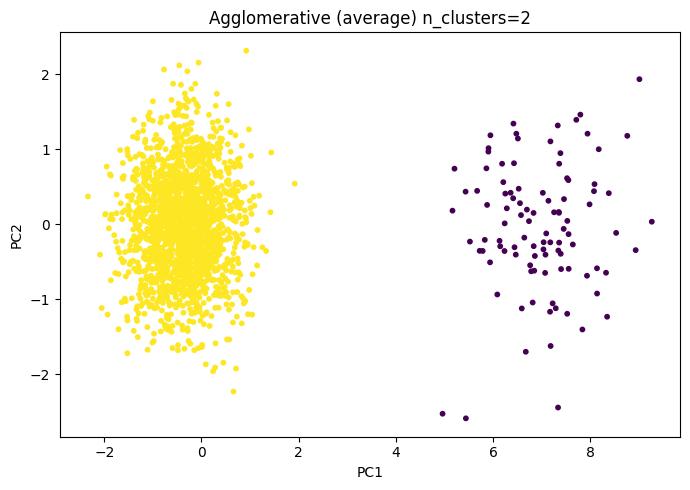

In [9]:
# 5 - Agglomerative + dendrograma
Z = linkage(X_scaled, method='ward')
plt.figure(figsize=(12,6))
dendrogram(Z, truncate_mode='lastp', p=50, show_contracted=True)
plt.title("Dendrograma (truncated) - Ward")
plt.xlabel("index")
plt.ylabel("distance")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR,"dendrogram_ward.png"))
plt.show()

agg_results = {}
for link in ['ward','complete','average']:
    for ncl in [2,3,4,5]:
        agg = AgglomerativeClustering(n_clusters=ncl, linkage=link)
        labs = agg.fit_predict(X_scaled)
        sil = silhouette_score(X_scaled, labs)
        agg_results[(link,ncl)] = {'silhouette': float(sil)}

# Mostrar melhores por linkage
best_per_link = {}
for link in ['ward','complete','average']:
    cand = {k:v for k,v in agg_results.items() if k[0]==link}
    best = max(cand.items(), key=lambda it: it[1]['silhouette'])
    best_per_link[link] = {'n_clusters': best[0][1], 'silhouette': best[1]['silhouette']}

print("Melhor por linkage (n_clusters, silhouette):", best_per_link)

# Salvar PCA plots para os melhores
for link,info in best_per_link.items():
    n = info['n_clusters']
    agg = AgglomerativeClustering(n_clusters=n, linkage=link)
    labs = agg.fit_predict(X_scaled)
    plt.figure(figsize=(7,5))
    plt.scatter(X_pca[:,0], X_pca[:,1], c=labs, s=10)
    plt.title(f"Agglomerative ({link}) n_clusters={n}")
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR,f"agg_{link}_n{n}_pca.png"))
    plt.show()


In [18]:
# Redefine DBSCAN parameters and results for summary, ensuring variables are defined
# These lines are taken from cell QVhq31D5sNjk to make this cell self-contained for the summary
# If you wish to re-evaluate DBSCAN, please run cell QVhq31D5sNjk separately.
chosen = (0.8,5)
db = DBSCAN(eps=chosen[0], min_samples=chosen[1])
db_labels = db.fit_predict(X_scaled)
n_noise = int((db_labels == -1).sum())
n_clusters = len(set(db_labels)) - (1 if -1 in db_labels else 0)

# 6 - Resumo
summary = {
    'shape': df.shape,
    'columns': df.columns.tolist(),
    'missing': df.isna().sum().to_dict(),
    'pca_variance_ratio': list(pca.explained_variance_ratio_),
    'kmeans': {'k_tested': k_range, 'inertias': inertias, 'silhouette_scores': sil_scores, 'best_k': int(best_k)},
    'dbscan_chosen': {'eps': chosen[0], 'min_samples': chosen[1], 'n_noise': int(n_noise), 'n_clusters': int(n_clusters)},
    'agglomerative_best_per_linkage': best_per_link
}
with open(os.path.join(OUT_DIR,"clustering_summary.json"), "w") as f:
    json.dump(summary, f, indent=2)

print("Resumo salvo em:", os.path.join(OUT_DIR,"clustering_summary.json"))
print("Imagens e arquivos salvos em:", OUT_DIR)

# Detailed prints
chosen_eps = chosen[0]
chosen_ms = chosen[1]
print("K-Means best k (por silhouette):", best_k)
print("K-Means silhouette scores:", dict(zip(list(k_range), [round(s,3) for s in sil_scores])))

print("\nDBSCAN chosen (eps, min_samples):", (chosen_eps, chosen_ms), "-> n_noise:", n_noise, "n_clusters:", n_clusters)

print("\nAgglomerative best per linkage:", best_per_link)

print("\n--- Respostas Sugeridas ---\n")
print("Tarefa 2 — K-Means:")
print(f"- k escolhido: {best_k} (maior Silhouette Score).")
print("- Visualmente: verifique o plot PCA kmeans_k{best_k}_pca.png; espera-se ver 2-4 nuvens; no dataset sintético: 3 grupos (carga leve/média/alta).")
print("\nTarefa 3 — DBSCAN:")
print(f"- Anomalias detectadas (label -1): aproximadamente {n_noise} pontos com eps={chosen_eps}, min_samples={chosen_ms}.")
print("- Coerência: se os pontos rotulados como -1 estiverem nas extremidades (ex.: temp altíssima, vibração incomum), a detecção é coerente.")
print("- Mudança ao alterar eps: diminuir eps -> mais ruído; aumentar eps -> menos ruído, possivelmente menos clusters.")
print("\nTarefa 4 — Hierarchical:")
for link,info in best_per_link.items():
    print(f"- {link}: melhor n_clusters = {info['n_clusters']}, silhouette = {info['silhouette']:.3f}")
print("- Dendrograma: olhe para o componente salvo dendrogram_ward.png para escolher corte (p.ex. 3).")
print("\nTarefa 5 — Comparação geral (recomendações):")
print("1) Grupos melhor definidos: K-Means ou Agglomerative(ward) para dados gaussianos/compactos.")
print("2) Melhor para anomalias: DBSCAN (marca ruído como -1).")
print("3) Dendrograma: sim, ajuda a ver quebras (use para escolher n_clusters).")
print("4) K-Means tende a clusters esféricos; faz sentido se regimes forem centrados/compactos.")
print("5) DBSCAN sensível aos parâmetros — ajuste eps via k-distance plot.")
print("6) Recomendação prática: combinar DBSCAN (detecção de anomalias) + K-Means/Agglomerative (segmentação de regimes).")

# Salvar summary
report = {
    'kmeans': {'tested_k': list(k_range), 'silhouette_scores': [float(s) for s in sil_scores], 'best_k': int(best_k)},
    'dbscan': {'chosen_eps': chosen_eps, 'chosen_min_samples': chosen_ms, 'n_noise': int(n_noise)},
    'agglomerative_best': best_per_link
}
with open(os.path.join(OUT_DIR,"automated_summary.json"), "w") as f:
    json.dump(report, f, indent=2)


Resumo salvo em: /content/clustering_results/clustering_summary.json
Imagens e arquivos salvos em: /content/clustering_results
K-Means best k (por silhouette): 2
K-Means silhouette scores: {2: 0.79, 3: 0.22, 4: 0.223, 5: 0.198, 6: 0.199}

DBSCAN chosen (eps, min_samples): (0.8, 5) -> n_noise: 63 n_clusters: 4

Agglomerative best per linkage: {'ward': {'n_clusters': 2, 'silhouette': 0.7898644627622996}, 'complete': {'n_clusters': 2, 'silhouette': 0.7898644627622996}, 'average': {'n_clusters': 2, 'silhouette': 0.7898644627622996}}

--- Respostas Sugeridas ---

Tarefa 2 — K-Means:
- k escolhido: 2 (maior Silhouette Score).
- Visualmente: verifique o plot PCA kmeans_k{best_k}_pca.png; espera-se ver 2-4 nuvens; no dataset sintético: 3 grupos (carga leve/média/alta).

Tarefa 3 — DBSCAN:
- Anomalias detectadas (label -1): aproximadamente 63 pontos com eps=0.8, min_samples=5.
- Coerência: se os pontos rotulados como -1 estiverem nas extremidades (ex.: temp altíssima, vibração incomum), a detec